In [4]:
import numpy as np
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        
#

In [8]:
import matplotlib.pyplot as plt
#
# Set file paths based on added MNIST Datasets
#

training_images_filepath = 'train-images-idx3-ubyte/train-images-idx3-ubyte'
training_labels_filepath ='train-labels-idx1-ubyte/train-labels-idx1-ubyte'
test_images_filepath = 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
test_labels_filepath = 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'


# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


<class 'numpy.uint8'>


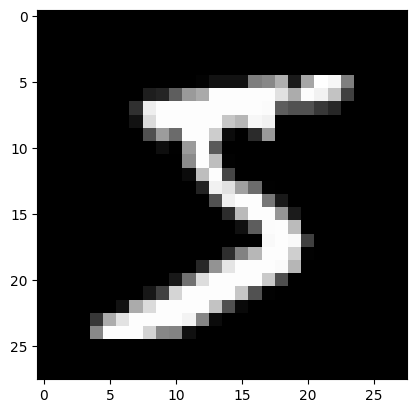

In [9]:
x_train.shape
plt.imshow(x_train[0],cmap='gray')
print(type(y_train[0]))

In [10]:
x_train.max(),x_train.min()


(np.uint8(255), np.uint8(0))

In [11]:
#reshaping and normalisation

x_train=(x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]).astype(np.float32)-127.5)/127.5
x_test=(x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2]).astype(np.float32)-127.5)/127.5


In [12]:
x_train.max(),x_train.min()

(np.float32(1.0), np.float32(-1.0))

In [13]:
#data shuffling
keys=np.array(range(x_train.shape[0]))
np.random.shuffle(keys)
x_train=x_train[keys]
y_train=y_train[keys]
y_train[:5]

array([5, 8, 1, 7, 3], dtype=uint8)

In [14]:
#model building
from network_full import *
model=Model()

model.add(layer_dense(x_train.shape[1],256))
model.add(Activation_ReLu())
model.add(Layer_Dropout(0.1))
model.add(layer_dense(256,128))
model.add(Activation_ReLu())
model.add(Layer_Dropout(0.1))
model.add(layer_dense(128,10))
model.add(Activation_SoftMax())
model.set(loss=Loss_CategoricalCrossEntropy(),
          optimizer=Optimizer_Adam(learning_rate=0.001,decay=1e-7),
          accuracy=Accuracy_Categorical())
model.finalize()




In [15]:
model.train(x_train,y_train,epochs=10,batch_size=64,print_every=100)


epoch: 1
 step: 0, acc: 0.109, loss: 2.302,data_loss: 2.302, reg_loss: 0.000 lr: 0.001000
 step: 100, acc: 0.797, loss: 0.632,data_loss: 0.632, reg_loss: 0.000 lr: 0.001000
 step: 200, acc: 0.844, loss: 0.449,data_loss: 0.449, reg_loss: 0.000 lr: 0.001000
 step: 300, acc: 0.875, loss: 0.457,data_loss: 0.457, reg_loss: 0.000 lr: 0.001000
 step: 400, acc: 0.859, loss: 0.368,data_loss: 0.368, reg_loss: 0.000 lr: 0.001000
 step: 500, acc: 0.844, loss: 0.599,data_loss: 0.599, reg_loss: 0.000 lr: 0.001000
 step: 600, acc: 0.891, loss: 0.411,data_loss: 0.411, reg_loss: 0.000 lr: 0.001000
 step: 700, acc: 0.938, loss: 0.194,data_loss: 0.194, reg_loss: 0.000 lr: 0.001000
 step: 800, acc: 0.953, loss: 0.184,data_loss: 0.184, reg_loss: 0.000 lr: 0.001000
 step: 900, acc: 0.875, loss: 0.291,data_loss: 0.291, reg_loss: 0.000 lr: 0.001000
 step: 937, acc: 0.969, loss: 0.332,data_loss: 0.332, reg_loss: 0.000 lr: 0.001000
training , acc: 0.861, loss: 0.445,data_loss: 0.445, reg_loss: 0.000 lr: 0.00100

In [16]:
model.evaluate(x_test,y_test,batch_size=64)

validation, acc:0.970 ,loss: 0.099 


In [17]:
model.save('hand_written_digits.model')